#### 我们对比的是JPMorgan(JPM)和Goldman(GS)来说配对交易，这两只股票的走势比较像，一旦走的比较像，我们就可以看看这两只股票是否存在协整关系
#### 我们不做stationary的部分，直接看non-stationary的部分，因为我们默认股票是有shift的趋势

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

## 前导知识

In [2]:
#我们后来讲协整会讲到最小二乘法以及线性回归
m = np.array([1,2,3,4,5])
n = m*5 + 2
m
##slope,intercept = np.polyfit(m,n,1).round(2)
##print(slope,intercept)

array([1, 2, 3, 4, 5])

## 1.数据准备 & 回测准备

In [5]:
data = pdr.get_data_yahoo(['JPM','GS'], start = '2018-1-1', end = '2019-7-25')['Close']
#data = pd.DataFrame(data)

data.head()

Symbols,JPM,GS
Date,,
2018-01-02,107.949997,255.669998
2018-01-03,108.059998,253.289993
2018-01-04,109.040001,256.829987
2018-01-05,108.339996,255.520004
2018-01-08,108.500000,251.809998


#### 这里我们再说一下如果我们一个个抽取股票信息，如何合并

In [6]:
stocks_pair = ['JPM','GS']
JPM = pdr.get_data_yahoo('JPM', start = '2018-1-1', end = '2019-7-25')[['Close']]
JPM = pd.DataFrame(JPM)
GS = pdr.get_data_yahoo('GS', start = '2018-1-1', end = '2019-7-25')[['Close']]
GS = pd.DataFrame(GS)
JPM
GS

,Close
Date,
2018-01-02,255.669998
2018-01-03,253.289993
2018-01-04,256.829987
2018-01-05,255.520004
2018-01-08,251.809998
...,...
2019-07-22,214.000000
2019-07-23,219.429993
2019-07-24,222.029999


In [7]:
data = pd.concat([JPM,GS],axis = 1)
data.columns = stocks_pair   #我们要把名字替换原本的close
data.head()

,JPM,GS
Date,,
2018-01-02,107.949997,255.669998
2018-01-03,108.059998,253.289993
2018-01-04,109.040001,256.829987
2018-01-05,108.339996,255.520004
2018-01-08,108.500000,251.809998


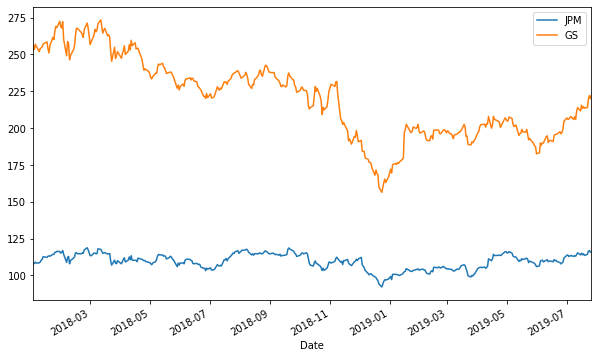

In [8]:
data.plot(figsize = (10,6))
plt.show()   
#我们可以看出GS的股价是高于JPM的，那么我们可以算出一个平均价差，然后给上下都有一个阈值，然后超过阈值的时候我们都是做多一部分做空一部分

#### 那么我们怎么去做这个价差呢？那么我们会考虑多因子，然后将多因子标准化。我们之所以要多因子标准化那是由于因子自身导致的，比如说市盈率和市净率可能是我们多因子中的两个，然后我们如果单独来比较市盈率和市净率就会发现可能前者20+后者就是个位数，那么其实不好比较。如果说我们又考虑这家公司的实体价值，那么可能就是几百亿，那么我们市盈率市净率的个位数或者双位数基本就可以忽略不计了，根本没办法比较。那么在这种情况下，我们就要对每个因子进行标准化。

#### 标准化有很多不同的方法，这里我们来讲一种：
##### standardized = (spread - spread.mean())/spread.std()  -> 这样子我们就可以将原本绝对的价差spread给标准化

#### 这样做的一个好处就是，比如说我们算出来是1.5倍标准差，那么我们就认为如果超过1.5倍这个范畴就是小概率事件，那么我们就会认为不可能持续在1.5倍范畴之外，那么如果在1.5倍范畴之外，我们就认为会均值回归
#### 但是这样做也有缺陷：如果我们这么做，那么我们就默认spread是符合正态分布的，从而我们才能用正态分布的方法来进行标准化。但是是否价差spread一定是正态分布呢？不一定，因为股票价格的return是符合正态分布的，但是股票之间的差我们其实不知道的。

#### 然后我们就可以用μ + 1.5倍标准差作为我们的上轨，μ - 1.5倍标准差作为我们的下轨

## 2.策略开发思路

#### 我们可以找到这两只股票之间的价差，只要价差足够大或者足够小都会做一个均值回归。

In [10]:
data['priceDelta'] = data['GS'] - data['JPM']  #这个就是价差
data.head()

,JPM,GS,priceDelta
Date,,,
2018-01-02,107.949997,255.669998,147.720001
2018-01-03,108.059998,253.289993,145.229996
2018-01-04,109.040001,256.829987,147.789986
2018-01-05,108.339996,255.520004,147.180008
2018-01-08,108.500000,251.809998,143.309998


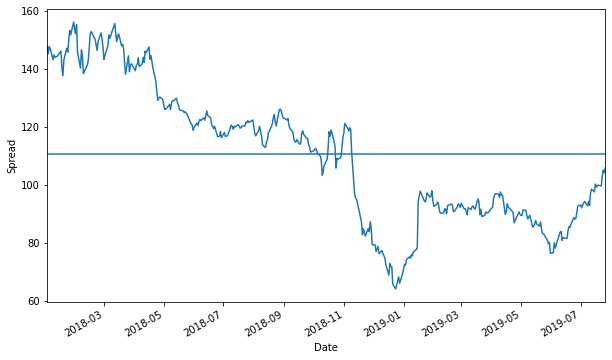

In [11]:
plt.figure()
data['priceDelta'].plot(figsize=(10,6))
plt.ylabel('Spread')
plt.axhline(data['priceDelta'].mean())  #这里其实就是说我们把这两只股票价差spread的均值画一条线
#plt.show()

#### 接下来我们就要做出一个standardized spread（Z-score）

In [12]:
data['zscore'] = (data['priceDelta'] - np.mean(data['priceDelta']))/np.std(data['priceDelta'])   #价差标准化，这里我们相当于把mean当做了0
data.head()

,JPM,GS,priceDelta,zscore
Date,,,,
2018-01-02,107.949997,255.669998,147.720001,1.577738
2018-01-03,108.059998,253.289993,145.229996,1.471837
2018-01-04,109.040001,256.829987,147.789986,1.580715
2018-01-05,108.339996,255.520004,147.180008,1.554772
2018-01-08,108.500000,251.809998,143.309998,1.390178


In [13]:
zscore_threshold = data['zscore'] < 1.5
data[zscore_threshold].head()  #这样就是把数据中zscore<1.5的给挑出来

,JPM,GS,priceDelta,zscore
Date,,,,
2018-01-03,108.059998,253.289993,145.229996,1.471837
2018-01-08,108.500000,251.809998,143.309998,1.390178
2018-01-09,109.050003,253.940002,144.889999,1.457377
2018-01-10,110.250000,254.330002,144.080002,1.422927
2018-01-11,110.839996,255.130005,144.290009,1.431859


In [15]:
zscore_threshold.head()  #如果是这样打印的话，那么其实如果< 1.5的就会显示True，反之是False,但是还是会把所有的内容打印出来

Date
2018-01-02    False
2018-01-03     True
2018-01-04    False
2018-01-05    False
2018-01-08     True
Name: zscore, dtype: bool

In [16]:
print(len(data[data['zscore']<-1.5])) #print出来是17，也就是说理论上我们可能存在17天的zscore是小于-1.5的

17


#### 如果这里zscore>1.5，那么说明价差是突破了上限，而我们价差是GS - JPM，那么就说明GS太多了，那么我们就要做空GS,做多JPM
#### 如果这里zscore<-1.5，那么说明价差是突破了下限，而我们价差是GS - JPM，那么就说明GS太少了，那么我们就要做多GS,做空JPM

#### 这里其实找到开仓和空仓的点并不难，难得是找到平仓的点，也就是mean = 0的时候。我们可以像做mean-reverting那样子，前后两个数据相乘小于0这么做
#### 但是如果我们这里是想要当我们的价差回到了正负0.5个标准差的范围内我们就平仓，因为如果要求回到0真的要求太严苛了，那么我们很多钱都赚不到了

In [17]:
data['position_GS'] = np.where(data['zscore'] > 1.5, -1, np.nan)   
#我们可以看出来，这里的position_1针对的是GS，如果大于1.5就说明GS-JPM价差太大，那么我们需要做空GS做多JPM。如果不是大于1.5那么就给一个nan，相当于我们后面要填充
data['position_GS'] = np.where(data['zscore'] < -1.5, 1, data['position_GS'])   
#如果小于-1.5相当于越过了下边的阈值，那么我们相当于就要做多GS，做空JPM
data['position_GS'] = np.where(abs(data['zscore']) < 0.5, 0, data['position_GS'])   
#abs()绝对值函数。我们这里其实就是在算正负0.5的标准差区间。剩下的如果不满足这个条件，你原来该是啥还是啥
data.head(10)

,JPM,GS,priceDelta,zscore,position_GS
Date,,,,,
2018-01-02,107.949997,255.669998,147.720001,1.577738,-1.0
2018-01-03,108.059998,253.289993,145.229996,1.471837,NaN
2018-01-04,109.040001,256.829987,147.789986,1.580715,-1.0
2018-01-05,108.339996,255.520004,147.180008,1.554772,-1.0
2018-01-08,108.500000,251.809998,143.309998,1.390178,NaN
2018-01-09,109.050003,253.940002,144.889999,1.457377,NaN
2018-01-10,110.250000,254.330002,144.080002,1.422927,NaN
2018-01-11,110.839996,255.130005,144.290009,1.431859,NaN
2018-01-12,112.669998,257.029999,144.360001,1.434835,NaN


### 产生交易信号

In [21]:
#对于空值我们需要向上填充。就是我们上一个信号是什么，理论上在下一个信号出来之前
data['position_GS'] = data['position_GS'].fillna(method = 'ffill')
data

,JPM,GS,priceDelta,zscore,position_GS
Date,,,,,
2018-01-02,107.949997,255.669998,147.720001,1.577738,-1.0
2018-01-03,108.059998,253.289993,145.229996,1.471837,-1.0
2018-01-04,109.040001,256.829987,147.789986,1.580715,-1.0
2018-01-05,108.339996,255.520004,147.180008,1.554772,-1.0
2018-01-08,108.500000,251.809998,143.309998,1.390178,-1.0
...,...,...,...,...,...
2019-07-22,114.269997,214.000000,99.730003,-0.463308,0.0
2019-07-23,116.360001,219.429993,103.069992,-0.321256,0.0
2019-07-24,116.830002,222.029999,105.199997,-0.230665,0.0


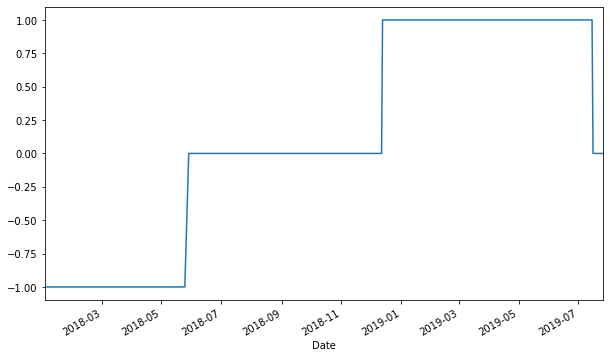

In [22]:
plt.figure()
data['position_GS'].plot(ylim = [-1.1,1.1], figsize = (10,6))

                   JPM          GS  priceDelta    zscore  position_GS  \
Date                                                                    
2018-01-02  107.949997  255.669998  147.720001  1.577738         -1.0   
2018-01-03  108.059998  253.289993  145.229996  1.471837         -1.0   
2018-01-04  109.040001  256.829987  147.789986  1.580715         -1.0   
2018-01-05  108.339996  255.520004  147.180008  1.554772         -1.0   
2018-01-08  108.500000  251.809998  143.309998  1.390178         -1.0   

            position_JPM  
Date                      
2018-01-02           1.0  
2018-01-03           1.0  
2018-01-04           1.0  
2018-01-05           1.0  
2018-01-08           1.0  


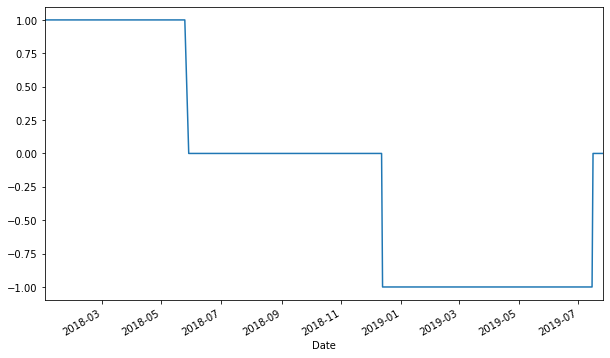

In [23]:
data['position_JPM'] = -np.sign(data['position_GS'])
print(data.head())
data['position_JPM'].plot(ylim = [-1.1,1.1], figsize = (10,6))
plt.show()  #这里说明这一年里一共开了2次仓。一次多仓一次空仓

## 3.计算策略年化收益并可视化

In [24]:
data['return_GS'] = np.log(data['GS']/data['GS'].shift(1))
data['return_JPM'] = np.log(data['JPM']/data['JPM'].shift(1))
data.head()

,JPM,GS,priceDelta,zscore,position_GS,position_JPM,return_GS,return_JPM
Date,,,,,,,,
2018-01-02,107.949997,255.669998,147.720001,1.577738,-1.0,1.0,NaN,NaN
2018-01-03,108.059998,253.289993,145.229996,1.471837,-1.0,1.0,-0.009352,0.001018
2018-01-04,109.040001,256.829987,147.789986,1.580715,-1.0,1.0,0.013879,0.009028
2018-01-05,108.339996,255.520004,147.180008,1.554772,-1.0,1.0,-0.005114,-0.006440
2018-01-08,108.500000,251.809998,143.309998,1.390178,-1.0,1.0,-0.014626,0.001476


In [25]:
#这里的特殊点在于我们的收益应该是两只股票同时给我们带来的
data['strategy'] = 0.5*(data['position_GS'].shift(1)*data['return_GS']) + 0.5*(data['position_JPM'].shift(1)*data['return_JPM'])
data

,JPM,GS,priceDelta,zscore,position_GS,position_JPM,return_GS,return_JPM,strategy
Date,,,,,,,,,
2018-01-02,107.949997,255.669998,147.720001,1.577738,-1.0,1.0,NaN,NaN,NaN
2018-01-03,108.059998,253.289993,145.229996,1.471837,-1.0,1.0,-0.009352,0.001018,0.005185
2018-01-04,109.040001,256.829987,147.789986,1.580715,-1.0,1.0,0.013879,0.009028,-0.002426
2018-01-05,108.339996,255.520004,147.180008,1.554772,-1.0,1.0,-0.005114,-0.006440,-0.000663
2018-01-08,108.500000,251.809998,143.309998,1.390178,-1.0,1.0,-0.014626,0.001476,0.008051
...,...,...,...,...,...,...,...,...,...
2019-07-22,114.269997,214.000000,99.730003,-0.463308,0.0,-0.0,0.002245,0.006409,0.000000
2019-07-23,116.360001,219.429993,103.069992,-0.321256,0.0,-0.0,0.025057,0.018125,0.000000
2019-07-24,116.830002,222.029999,105.199997,-0.230665,0.0,-0.0,0.011779,0.004031,0.000000


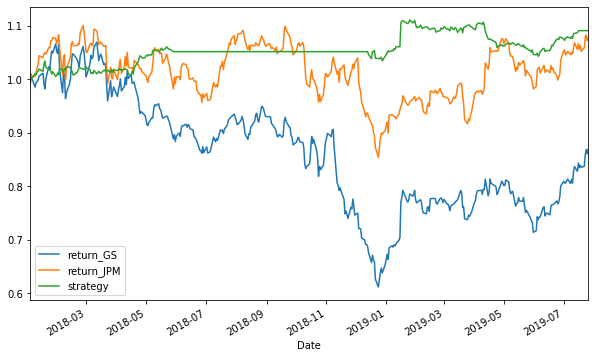

In [26]:
data[['return_GS','return_JPM','strategy']].dropna().cumsum().apply(np.exp).plot(figsize = (10,6))
plt.show()